This notebook can be used to quickly generate additional output for comparing results. It is based on the test cases run on TeamCity as part of the continuous testing framework for the VRTOOL. However, it can also be used to directly compare 2 different databases.

### Import necessary libraries

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn

from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.common_functions.database_analytics import *
from postprocessing.common_functions.database_access_functions import * 
from postprocessing.common_functions.generate_output import *

sns.set(style="whitegrid")
colors = sns.color_palette("colorblind", 10)


### Get the runs that are in both databases
First we get an overview of the runs in both databases

In [2]:
result_path = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\N=4 database\38-1\38-1_basis.db')
result_runs = get_overview_of_runs(result_path)

reference_path = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\05_Handreiking\casus_ontwerpen\38-1\38-1_basis.db')
reference_runs = get_overview_of_runs(reference_path)

pd.DataFrame(result_runs + reference_runs)

,id,name,discount_rate,optimization_type,optimization_type_name
0,1,Basisberekening Veiligheidsrendement,0.016,1,VEILIGHEIDSRENDEMENT
1,2,Basisberekening Doorsnede-eisen,0.016,2,DOORSNEDE-EISEN
2,1,Basisberekening Veiligheidsrendement,0.030,1,VEILIGHEIDSRENDEMENT
3,2,Basisberekening Doorsnede-eisen,0.030,2,DOORSNEDE-EISEN


Now we set the ids of the runs in result & reference. 
Additionally, we set whether we want to consider revetment or not (important later on) and whether we want to take the last investment step, or the optimal.

In [3]:
id_for_result = 1
id_for_reference = 1
has_revetment = False    #Whether a revetment is present or not
take_last = False       #If True, the last step is taken, if False, the step with minimal total cost is taken

For each run, we get the optimization steps and the index of the step with minimal total costs. This is the optimal combination of measures.

In [4]:
optimization_steps = {'reference': get_optimization_steps_for_run_id(reference_path, id_for_reference),
                      'result': get_optimization_steps_for_run_id(result_path, id_for_result)}	

# add total cost as sum of total_lcc and total_risk in each step
if not take_last:
    considered_tc_step = {'reference': get_minimal_tc_step(optimization_steps['reference'])-1,
                        'result': get_minimal_tc_step(optimization_steps['result'])-1}
else:
    considered_tc_step = {'reference': len(optimization_steps['reference'])-1,
                        'result': len(optimization_steps['result'])-1}

This plot shows the results for total cost and risk for both runs. 
If these values are equal it means that the steps are identical.

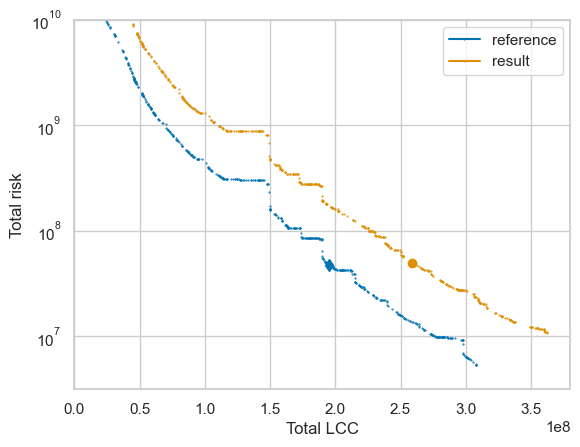

In [5]:
fig, ax = plt.subplots()
markers = ['d', 'o']
for count, run in enumerate(optimization_steps.keys()):
    plot_lcc_tc_from_steps(optimization_steps[run], axis=ax, lbl  = run, clr = colors[count])
    ax.plot(optimization_steps[run][considered_tc_step[run]]['total_lcc'], optimization_steps[run][considered_tc_step[run]]['total_risk'], markers[count], color = colors[count])
ax.set_xlabel('Total LCC')
ax.set_ylabel('Total risk')
ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_ylim(top=1e10)
ax.legend()

This figure gives us insight in the difference between the reference and the new result: in principle the points generated for the new result should be closer to the origin than that of the reference, otherwise the performance of the optimization has worsened. However, also large changes should of course be explained. 

The latter is the focus of the following steps.

### Reading measures per step
The next step is to read the measures and parameters of these measures for each optimization step such that we can compare the measures that are taken in each step and for each section.

In [6]:
lists_of_measures = {'reference': get_measures_for_run_id(reference_path, id_for_reference),
                     'result': get_measures_for_run_id(result_path, id_for_result)}

measures_per_step = {'reference': get_measures_per_step_number(lists_of_measures['reference']),
                        'result': get_measures_per_step_number(lists_of_measures['result'])}

If we want to see the failure probability per stap we first need to load the original assessment for each mechanism, and then we can compute the reliability for each step during the optimization. 

In [7]:
assessment_results = {'reference': {}, 'result': {}}
for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER, MechanismEnum.REVETMENT]:
    if has_revetment or mechanism != MechanismEnum.REVETMENT:
        assessment_results['reference'][mechanism] = import_original_assessment(reference_path, mechanism)
        assessment_results['result'][mechanism] = import_original_assessment(result_path, mechanism)


reliability_per_step = {'reference': get_reliability_for_each_step(reference_path, measures_per_step['reference']),
                        'result': get_reliability_for_each_step(result_path, measures_per_step['result'])}

Based on these inputs we can make a stepwise_assessment based on the investments in reliability_per_step.

In [ ]:
stepwise_assessment = {'reference': assessment_for_each_step(copy.deepcopy(assessment_results['reference']), reliability_per_step['reference']),
                        'result': assessment_for_each_step(copy.deepcopy(assessment_results['result']), reliability_per_step['result'])}

The next step is to derive the traject probability for each mechanism for each step using the `calculate_traject_probability_for_steps` function

In [57]:
traject_prob = {'reference': calculate_traject_probability_for_steps(stepwise_assessment['reference']),
                'result': calculate_traject_probability_for_steps(stepwise_assessment['result'])}

(0.0, 100.0)

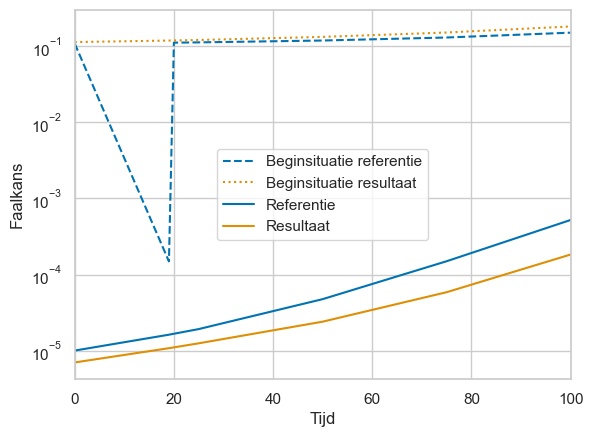

In [47]:
fig, ax  = plt.subplots()

plot_traject_probability_for_step(traject_prob['reference'][0], ax, run_label='Beginsituatie referentie',color=colors[0], linestyle = '--')
plot_traject_probability_for_step(traject_prob['result'][0], ax, run_label='Beginsituatie resultaat',color=colors[1], linestyle=':')
plot_traject_probability_for_step(traject_prob['reference'][considered_tc_step['reference']], ax, run_label='Referentie',color=colors[0], linestyle = '-')
plot_traject_probability_for_step(traject_prob['result'][considered_tc_step['result']], ax, run_label='Resultaat', color=colors[1], linestyle='-')
ax.set_xlim(left=0,right=100)

Now we are going to print the MeasureResultIds for each section for both runs

In [38]:
measures_per_section = {'reference': get_measures_per_section_for_step(measures_per_step['reference'], considered_tc_step['reference']+1),
                        'result': get_measures_per_section_for_step(measures_per_step['result'], considered_tc_step['result']+1)}

for section in set(list(measures_per_section['result'].keys())+ list(measures_per_section['reference'].keys())):
    for run in measures_per_section.keys():
        try:
            print(f"Section {section} in run {run} has measures {measures_per_section[run][section]}")  
        except:
            print(f"Section {section} in run {run} has no measures in run {run}")

Section 1 in run reference has measures ([217, 25], [0, 0])
Section 1 in run result has measures ([217, 38], [0, 0])
Section 2 in run reference has measures ([437, 235], [0, 0])
Section 2 in run result has measures ([437, 244], [0, 0])
Section 3 in run reference has measures ([657, 452], [0, 0])
Section 3 in run result has measures ([657, 462], [0, 0])
Section 4 in run reference has measures ([877, 674], [0, 0])
Section 4 in run result has measures ([877, 683], [0, 0])
Section 5 in run reference has measures ([1097, 905], [0, 0])
Section 5 in run result has measures ([1097, 915], [0, 0])
Section 6 in run reference has measures ([1238], [0])
Section 6 in run result has measures ([1254], [0])
Section 7 in run reference has measures ([1337], [0])
Section 7 in run result has measures ([1346], [0])
Section 8 in run reference has measures ([1564], [0])
Section 8 in run result has measures ([1572], [0])
Section 9 in run reference has measures ([1882], [0])
Section 9 in run result has measures

Based on this we can see if the ids of the measures are identical. If these are identical & the measures given as input are also identical this shows that the result is the same. 

However, to further check this we also get the parameters of the measure + timing + cost for each section.

In [39]:
section_parameters = {'reference':{}, 'result': {}}

for section in measures_per_section['reference'].keys():
    section_parameters['reference'][section] = []
    for measure in measures_per_section['reference'][section][0]:
        parameters = get_measure_parameters(measure, reference_path)
        parameters.update(get_measure_costs(measure, reference_path))
        parameters.update(get_measure_type(measure, reference_path))
        section_parameters['reference'][section].append(parameters)

for section in measures_per_section['result'].keys():
    section_parameters['result'][section] = []
    for measure in measures_per_section['result'][section][0]:
        parameters = get_measure_parameters(measure, result_path)
        parameters.update(get_measure_costs(measure, result_path))
        parameters.update(get_measure_type(measure, result_path))
        section_parameters['result'][section].append(parameters)


Next we put this in a DataFrame such that we can easily compare the DataFrames of both runs.

In [40]:
measure_parameters = {'reference': measure_per_section_to_df(measures_per_section['reference'], section_parameters['reference']),
                        'result': measure_per_section_to_df(measures_per_section['result'], section_parameters['result'])}

Potentially we can export this to csv:

In [41]:
measure_parameters['reference'].to_csv('reference_measures.csv')
measure_parameters['result'].to_csv('result_measures.csv')

## Analysis of reliability index
Finally we can take a look into the reliability indices that have been computed in both runs. 

For instance, if a certain section has a relatively high $\beta$ this might indicate that the measure at that section is suboptimal and could give clues for inaccuracies of the algorithm. 

First we pick `t_analyzed`, the time at which we analyze the $\beta$ 

In [42]:
#IMPORTANT: this variable sets the time at which the beta is analyzed
t_analyzed = 0

#get betas for each section and mechanism at t_analyzed
betas_per_section_and_mech = {'result': get_beta_for_each_section_and_mech_at_t(stepwise_assessment['result'][considered_tc_step['result']], t_analyzed),
                                'reference': get_beta_for_each_section_and_mech_at_t(stepwise_assessment['reference'][considered_tc_step['reference']], t_analyzed)}

# transform dicts to dataframe
for run in betas_per_section_and_mech.keys():
    betas_per_section_and_mech[run] = pd.DataFrame.from_dict(betas_per_section_and_mech[run]).rename_axis('section_id').reset_index()
    betas_per_section_and_mech[run]['run'] = run 

betas_per_section_and_mechanism = pd.concat([betas_per_section_and_mech['result'], betas_per_section_and_mech['reference']], ignore_index = True)
betas_per_section_and_mechanism = pd.melt(betas_per_section_and_mechanism, id_vars = ['section_id', 'run'], var_name = 'mechanism', value_name = 'beta')

Next we make a plot to compare the $\beta$ for both runs

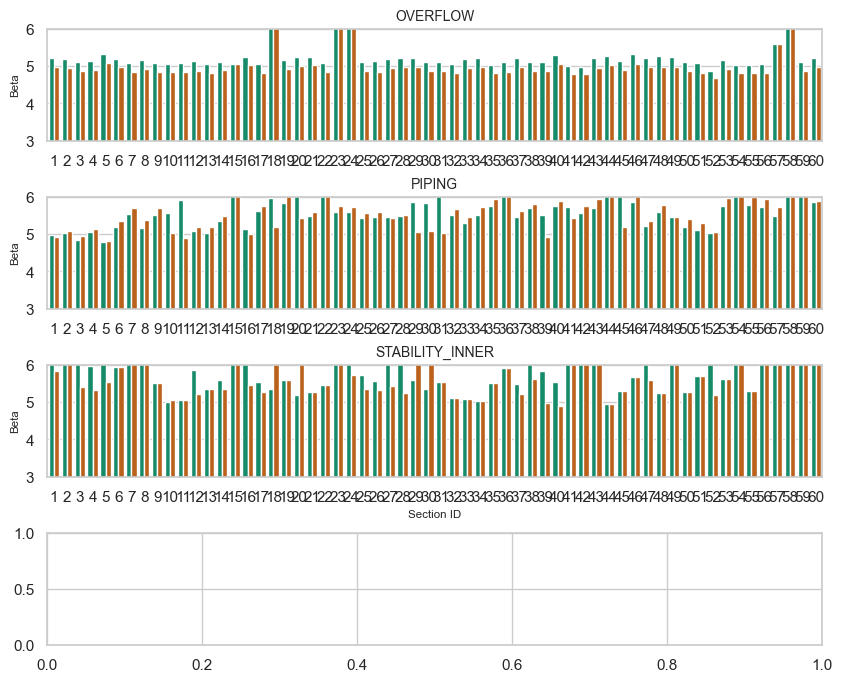

In [43]:
plot_comparison_of_beta_values(betas_per_section_and_mechanism)

Differences can also be revealing. First we plot the betas for different mechanisms on a diagonal axis to identify if any values deviate and by how much.

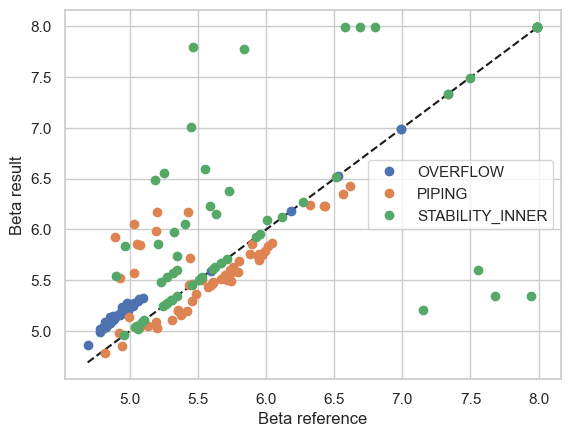

In [44]:
plot_difference_in_betas(betas_per_section_and_mechanism, has_revetment)
#TODO add automatic labels of SectionId or something similar

Next we do the same, but subtract the values and display per section:

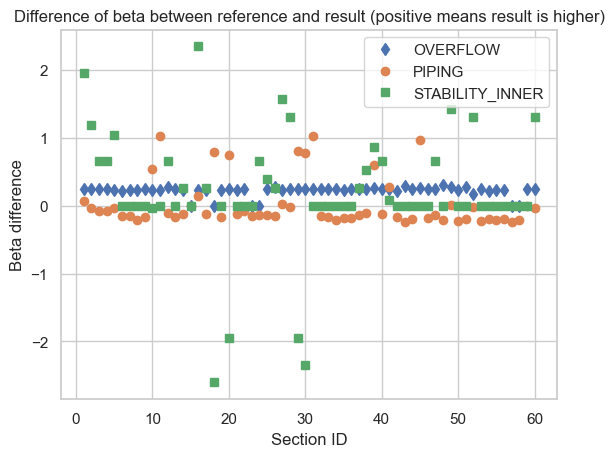

In [45]:
plot_difference_in_betas_per_section(betas_per_section_and_mechanism, has_revetment)